# Plan
- Train BERT classification_model_stage_1 <br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load libraries
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet
!pip install transformers==4.17 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.69 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.0 MB/s eta 0:00:00


In [ ]:
#@title Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
#import tensorflow_datasets as tfds
# import tensorflow_text as tf_text
import transformers

from transformers import logging
logging.set_verbosity_error()

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import os

import nltk
from nltk.data import find
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

import matplotlib.pyplot as plt

import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

from transformers import BertTokenizer, TFBertModel
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
"""
Training Data: made from notebook: Highlight Matching
Highlights Data: Made from notebook: Stage2_Chunks
"""
final_data_folder = '/content/drive/MyDrive/266 Final Project/Full Orchestration: Stage 1+2/final_data/'
training_data = pd.read_csv(final_data_folder + 'chunk_training_data.csv')
testing_data = pd.read_csv(final_data_folder + 'chunk_testing_data.csv')

# Train Stage 1 Classification

In [ ]:
MAX_SEQUENCE_LENGTH = 512

def tokenize_with_separator(X, y):

  X_examples = [f" {bert_tokenizer.sep_token} ".join(sent_tokenize(x)) for x in X]

  bert_input_tokenized = bert_tokenizer(X_examples,
                                        max_length=MAX_SEQUENCE_LENGTH,
                                        truncation=True,
                                        padding='max_length',
                                        return_tensors='tf')

  bert_inputs = [bert_input_tokenized.input_ids,
                      bert_input_tokenized.token_type_ids,
                      bert_input_tokenized.attention_mask]

  bert_labels = np.array(y)

  return bert_inputs, bert_labels

In [ ]:
bert_train_inputs, bert_train_labels = tokenize_with_separator(training_data['doc_text'], training_data['label'])
bert_test_inputs, bert_test_labels = tokenize_with_separator(testing_data['doc_text'], testing_data['label'])

In [ ]:
def create_bert_cls_model(
                          # bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):

    bert_base_model = TFBertModel.from_pretrained('bert-base-uncased')

    # bert_base_model.trainable = True
    # Freeze the embedding layer
    for param in bert_base_model.bert.embeddings.weights:
        param._trainable = True

    # Freeze the first 6 encoder layers (0-5)
    for param in bert_base_model.bert.encoder.layer[0:6]:
        param._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model.bert(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy', keras.metrics.Recall()])

    return classification_model, bert_base_model

In [ ]:
tf.keras.backend.clear_session()

bert_classification_model, trained_bert_model = create_bert_cls_model()

bert_classification_model_history = bert_classification_model.fit(
    bert_train_inputs,
    bert_train_labels,
    validation_data = (bert_test_inputs, bert_test_labels),
    batch_size = 8,
    epochs = 3
)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Epoch 1/3


1196/1196 [==============================] - 1244s 1s/step - loss: 0.6484 - accuracy: 0.6244 - recall: 0.6578 - val_loss: 0.5139 - val_accuracy: 0.7148 - val_recall: 0.6789
Epoch 2/3
1196/1196 [==============================] - 1223s 1s/step - loss: 0.4962 - accuracy: 0.7643 - recall: 0.8060 - val_loss: 0.7822 - val_accuracy: 0.5969 - val_recall: 0.9022
Epoch 3/3
1196/1196 [==============================] - 1222s 1s/step - loss: 0.3189 - accuracy: 0.8684 - recall: 0.8842 - val_loss: 0.7757 - val_accuracy: 0.7299 - val_recall: 0.8261


In [ ]:
bert_classification_model.save("/content/drive/MyDrive/266 Final Project/Full Orchestration: Stage 1+2/model_checkpoints/bert_chunk_classification_model/", save_format="tf")

In [ ]:
tf.keras.backend.clear_session()

# Run Stage 1 Model on Test Data (Keep True Positives)

In [ ]:
# Install the required libraries
!pip install gspread google-auth --quiet

# Import libraries
import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.auth import default
from gspread_dataframe import set_with_dataframe
from gspread_dataframe import get_as_dataframe
import seaborn as sns

# Authenticate and create a client
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
# Read in test data
final_data_path = "/content/drive/MyDrive/266 Final Project/Full Orchestration: Stage 1+2/final_data/"
chunk_testing_data = pd.read_csv(final_data_path + 'chunk_testing_data.csv')

In [ ]:
# Tokenize test data
MAX_SEQUENCE_LENGTH = 512

def tokenize_with_separator(X):

  X_examples = [f" {bert_tokenizer.sep_token} ".join(sent_tokenize(x)) for x in X]

  bert_input_tokenized = bert_tokenizer(X_examples,
                                        max_length=MAX_SEQUENCE_LENGTH,
                                        truncation=True,
                                        padding='max_length',
                                        return_tensors='tf')

  bert_inputs = [bert_input_tokenized.input_ids,
                      bert_input_tokenized.token_type_ids,
                      bert_input_tokenized.attention_mask]

  return bert_inputs

bert_inputs = tokenize_with_separator(chunk_testing_data['doc_text'])

In [ ]:
# Read in the trained model
bert_chunk_model = tf.keras.models.load_model("/content/drive/MyDrive/266 Final Project/Full Orchestration: Stage 1+2/model_checkpoints/bert_chunk_classification_model/")

In [ ]:
# Get predictions
stage_1_predictions = bert_chunk_model.predict(bert_inputs)
chunk_testing_data['prediction'] = (stage_1_predictions > 0.5).astype(int)

170/170 [==============================] - 207s 1s/step


In [ ]:
chunk_testing_data.head()

,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label,prediction
0,186,Flickr,Privacy Policy - April 30th 2020,If you do not receive timely acknowledgment of...,NaN,NaN,0,0
1,1597,Huawei,Privacy Policy,Huawei will release the methods for withdrawin...,NaN,NaN,0,0
2,3144,OneSignal,Privacy Policy,"Introduction and Background \nOneSignal, a U.S...",NaN,NaN,0,1
3,846,Crunchyroll,Privacy Policy,To comply with tax or accounting rules or othe...,NaN,NaN,0,0
4,2315,Fandango,Cookies and Tracking,We and third parties may associate Measurement...,NaN,NaN,0,1


In [ ]:
# Get type mapping
data_spreadsheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/12C-A9wGs-5snsP5_P9kKj0iZzXZS5cr0lBL-AhMX8Qc/edit?gid=0#gid=0")
mapping_ws = data_spreadsheet.worksheet("Type Mapping")
mapping_df = get_as_dataframe(mapping_ws, evaluate_formulas=True)
mapping_df = mapping_df.rename(columns={'segment_name':'doc_type'})

In [ ]:
mapping_df = mapping_df[['doc_type','segment_type']]
chunk_testing_data = chunk_testing_data.merge(mapping_df, on="doc_type", how="left")
chunk_testing_data

,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label,prediction,segment_type
0,186,Flickr,Privacy Policy - April 30th 2020,If you do not receive timely acknowledgment of...,NaN,NaN,0,0,Privacy Policy
1,1597,Huawei,Privacy Policy,Huawei will release the methods for withdrawin...,NaN,NaN,0,0,Privacy Policy
2,3144,OneSignal,Privacy Policy,"Introduction and Background \nOneSignal, a U.S...",NaN,NaN,0,1,Privacy Policy
3,846,Crunchyroll,Privacy Policy,To comply with tax or accounting rules or othe...,NaN,NaN,0,0,Privacy Policy
4,2315,Fandango,Cookies and Tracking,We and third parties may associate Measurement...,NaN,NaN,0,1,Cookie Policy
...,...,...,...,...,...,...,...,...,...
5405,698,Sync,Terms of Service,C ANY INFORMATION OBTAINED BY YOU AS A RESULT ...,NaN,NaN,0,1,Terms
5406,687,FastMail,2FA,"We do recommend YubiKey, as in our experience ...",NaN,NaN,0,0,Other
5407,707,Nextcloud,Privacy,Only a header with a subject is sent via Googl...,How do we use your information?,The service provides information about how the...,1,0,Privacy Policy
5408,264,VKontakte,Privacy Policy,Information containing the Site activity histo...,NaN,NaN,0,0,Privacy Policy


In [ ]:
chunk_testing_data['segment_type'].value_counts()

,count
segment_type,
Privacy Policy,2277
Terms,2089
Other,434
Cookie Policy,244
FAQ,38
Data,24


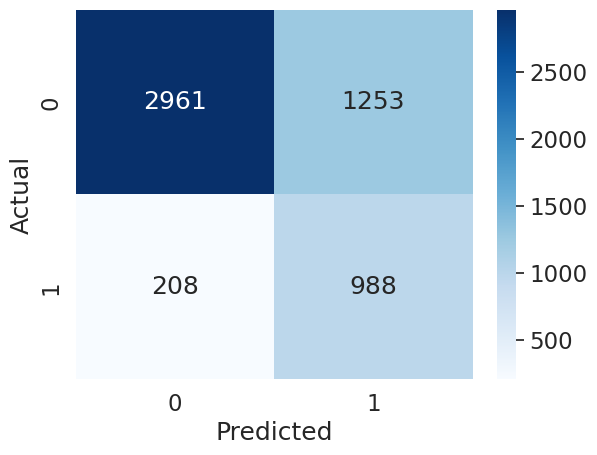

In [ ]:
sns.set(font_scale=1.5)

cm = confusion_matrix(chunk_testing_data['label'], chunk_testing_data['prediction'], labels = [0, 1])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

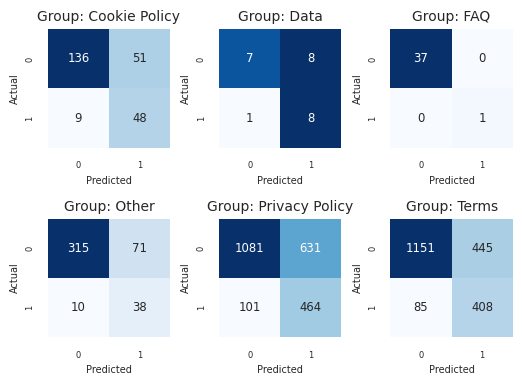

In [ ]:
grouped = chunk_testing_data.groupby("segment_type")

confusion_matrices = {}

for group_name, group_data in grouped:
    cm = confusion_matrix(group_data["label"], group_data["prediction"])
    confusion_matrices[group_name] = cm

sns.set(font_scale=0.7)

rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))

# Flatten axes array for easy indexing
axes = axes.flatten()

for idx, (group_name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[idx])
    axes[idx].set_title(f"Group: {group_name}", fontsize=10)
    axes[idx].set_xlabel("Predicted", fontsize=7)
    axes[idx].set_ylabel("Actual", fontsize=7)
    axes[idx].tick_params(labelsize=6)  # X-axis tick font size
    axes[idx].tick_params(labelsize=6)

plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.show()